# Modeling Reversal Task

### RW model of the reversal task in the aging experiment

The aim of this notbook is to see if age affects appetative reversal learning.

participants have 70 trials 40% reinforced.

reversal of stimuli occurs after 35 trials.

This notbook is based on Or's simulation of SCR.

## load libraries

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os

import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import statsmodels.formula.api as smf

from glob import glob

## Get data

make sure only participant with complete data set are loaded

In [2]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'

db = pd.DataFrame()

for sub in glob(glober):
    
    try:
        df = pd.read_csv(sub)
        df['sub'] = sub.split('_')[2]
        if df.shape[0] == 70:
            
            db = db.append(df[df.trialNum<36])
    except:
        print(sub)
        print('error')

#db['rating'] = db['rating'].replace(0, np.nan)
print('number of subject: ', len(db['sub'].unique()))

number of subject:  49


## get descriptive data

In [3]:
n_subj   = len(db['sub'].unique())
n_trials = max(db.trialNum)

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj   = tt.as_tensor_variable(subj.T)

In [4]:
stim   = np.reshape([db['rectOri']],   (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']],    (n_subj, n_trials)).T

stim   = np.array(stim/45,  dtype='int')
reward = np.array(reward/6*9, dtype='int')

In [5]:
stim = tt.as_tensor_variable(stim)
reward = tt.as_tensor_variable(reward)

# create a pymc3 model

In [6]:
 
# generate functions to run
def update_Q(stim, reward,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = reward - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

In [7]:
# try alpha as beta distribution
with pm.Model() as mB:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 197 seconds.


In [8]:
az.summary(trB, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.052,0.029,0.000,0.102,0.001,0.000,2777.0,1559.0,1.0
alpha[1],0.039,0.018,0.001,0.069,0.000,0.000,2050.0,910.0,1.0
alpha[2],0.026,0.017,0.000,0.055,0.000,0.000,2583.0,1387.0,1.0
alpha[3],0.079,0.030,0.024,0.133,0.001,0.000,3015.0,2009.0,1.0
alpha[4],0.023,0.016,0.000,0.051,0.000,0.000,2598.0,1993.0,1.0
alpha[5],0.038,0.029,0.000,0.087,0.001,0.000,2097.0,1444.0,1.0
alpha[6],0.014,0.011,0.000,0.034,0.000,0.000,2840.0,1814.0,1.0
alpha[7],0.117,0.040,0.043,0.190,0.001,0.000,3182.0,2321.0,1.0
alpha[8],0.052,0.033,0.001,0.109,0.000,0.000,3450.0,1878.0,1.0
alpha[9],0.026,0.020,0.000,0.062,0.000,0.000,2509.0,1725.0,1.0


In [9]:
# try with intercept
with pm.Model() as mB_I:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_I = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 197 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
az.summary(trB_I, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.582,0.262,0.123,1.000,0.004,0.003,4768.0,2391.0,1.0
alpha[1],0.111,0.083,0.000,0.232,0.002,0.002,3663.0,1934.0,1.0
alpha[2],0.154,0.104,0.000,0.332,0.002,0.001,3580.0,1938.0,1.0
alpha[3],0.255,0.104,0.067,0.451,0.002,0.001,4403.0,2060.0,1.0
alpha[4],0.115,0.088,0.000,0.273,0.001,0.001,3680.0,1699.0,1.0
alpha[5],0.489,0.226,0.085,0.924,0.004,0.003,3286.0,1919.0,1.0
alpha[6],0.377,0.297,0.000,0.891,0.005,0.004,3916.0,2837.0,1.0
alpha[7],0.414,0.151,0.143,0.705,0.003,0.002,3676.0,1943.0,1.0
alpha[8],0.487,0.285,0.005,0.932,0.004,0.003,5430.0,2342.0,1.0
alpha[9],0.469,0.283,0.000,0.923,0.004,0.003,4434.0,2601.0,1.0


In [11]:
az.compare({'model1': trB, 'model2':trB_I})

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-4101.342000,81.081250,0.000000,0.862673,25.667963,0.000000,True,log
model2,1,-4142.566014,74.514335,41.224014,0.137327,22.974535,10.713163,False,log


In [12]:
# try with intercept
with pm.Model() as mB_Is:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_Is = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 899 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
az.summary(trB_Is, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.343,0.324,0.000,0.907,0.007,0.005,2039.0,2544.0,1.0
alpha[1],0.144,0.210,0.000,0.629,0.004,0.003,2591.0,1777.0,1.0
alpha[2],0.271,0.242,0.000,0.744,0.004,0.003,2157.0,2145.0,1.0
alpha[3],0.165,0.116,0.009,0.369,0.002,0.001,3401.0,2059.0,1.0
alpha[4],0.284,0.266,0.000,0.808,0.005,0.004,1565.0,1929.0,1.0
alpha[5],0.404,0.239,0.000,0.814,0.004,0.003,2986.0,1579.0,1.0
alpha[6],0.338,0.284,0.000,0.874,0.005,0.004,2056.0,1434.0,1.0
alpha[7],0.276,0.142,0.040,0.528,0.002,0.002,3666.0,1932.0,1.0
alpha[8],0.289,0.278,0.000,0.848,0.005,0.004,1698.0,2085.0,1.0
alpha[9],0.383,0.294,0.000,0.889,0.007,0.005,1535.0,1608.0,1.0


In [14]:
az.compare({'model1': trB, 'model2':trB_I, 'model3':trB_Is})

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-4098.001929,106.029952,0.000000,5.897614e-01,25.380207,0.000000,False,log
model1,1,-4101.342000,81.081250,3.340071,4.102386e-01,25.667963,6.829368,True,log
model2,2,-4142.566014,74.514335,44.564086,9.992007e-16,22.974535,9.116228,False,log


## hierarchal model

In [15]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_hB = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1946 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9612888080508708, but should be close to 0.9. Try to increase the number of tuning steps.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8168502366291275, but should be close to 0.9. Try to increase the number of tuning steps.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
az.summary(tr_hB, var_names='alpha')[:10]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.048,0.034,0.000,0.108,0.001,0.001,579.0,561.0,1.01
alpha[1],0.032,0.026,0.000,0.077,0.001,0.000,970.0,611.0,1.00
alpha[2],0.024,0.029,0.000,0.073,0.001,0.001,522.0,544.0,1.01
alpha[3],0.092,0.060,0.000,0.195,0.002,0.002,578.0,925.0,1.01
alpha[4],0.017,0.023,0.000,0.056,0.001,0.001,681.0,900.0,1.00
alpha[5],0.047,0.065,0.000,0.166,0.002,0.002,570.0,540.0,1.01
alpha[6],0.010,0.016,0.000,0.032,0.000,0.000,637.0,1001.0,1.00
alpha[7],0.157,0.087,0.014,0.317,0.004,0.003,328.0,993.0,1.02
alpha[8],0.047,0.044,0.000,0.121,0.002,0.002,867.0,874.0,1.01
alpha[9],0.020,0.023,0.000,0.063,0.001,0.000,722.0,837.0,1.01


## model comparison

In [17]:
comp = az.compare({'model1':trB, 'model2': tr_hB}, ic='loo')
comp

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2,0,-4085.274658,66.166883,0.000000,1.000000e+00,23.379180,0.000000,False,log
model1,1,-4101.342000,81.081250,16.067343,6.554757e-13,25.667963,5.445579,True,log


<AxesSubplot:xlabel='Log'>

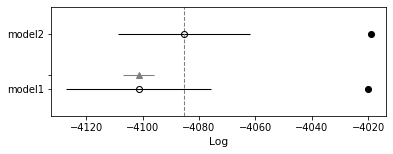

In [18]:
az.plot_compare(comp)

## Correlate expected value and subject data

In [19]:
a = trB.posterior.stack(draws=('chain','draw'))
a = a.expected_value
mean_a = np.mean(a, axis=2)
mean_a.shape

(35, 49)

In [20]:
for i in np.arange(10):
    cor1 = scipy.stats.pearsonr(rating[:,i], mean_a[:,i])
    print(cor1)

(0.27892827168710455, 0.1046705904167483)
(0.3780308551516219, 0.0251521131189318)
(0.146632848682171, 0.40060357184691947)
(0.5043119470447103, 0.0020075948139449185)
(0.103949771127254, 0.5523419431558565)
(0.09714864186687253, 0.5787700805757358)
(-0.19253298712026426, 0.26782704952544334)
(0.3829978955931457, 0.023151390120439947)
(0.3697169110796787, 0.02881916008784062)
(0.014020547755306584, 0.936286498769684)


## The Pearce-Hall Hybrid model

This is Or's attempt to build the PH Hybrid model. This model doesn't assume a simple constant learning rate (as the RW), rather, it incorporated both a constant learning rate and a dynamic one. The dynamic one is being updated by the amount of new information given. The model goes like that: 

(1) Vi(k+1) = Vi (k) + (k) + κα(k)δ

(2) δ = shock - Vi(k) 

(3) α(k+1) = μ|δ| + (1-μ)α(k)

So the current value is an update of the previous one plus a constant learning rate (kappa) and an associability weight (alpha) (times the delta = prediction error).

The α is set by a constant weight of associability (eta) and the previous α.

So now, our updating function will include those elements as well

In [21]:
# generate functions to run
def update_Q_hb(stim, shock,
             Qs,vec,alpha,assoc,
             eta,kappa, n_subj):
    """
    This function updates the Q table according to Hybrid PH model
    For information, please see this paper: https://www.sciencedirect.com/science/article/pii/S0896627316305840?via%3Dihub
  
    """
      
    delta = shock - Qs[tt.arange(n_subj), stim]
    alpha = tt.set_subtensor(alpha[tt.arange(n_subj), stim], eta * abs(delta) + (1-eta)*alpha[tt.arange(n_subj), stim])
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + kappa*alpha[tt.arange(n_subj), stim] * delta)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    # we use the same idea to get the associability per trial
    assoc = tt.set_subtensor(assoc[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                alpha[tt.arange(n_subj),1], alpha[tt.arange(n_subj),0])))
    
    return Qs, vec, alpha, assoc

In [25]:
with pm.Model() as m:
  
    # hyperpriors for eta and kappa
    phi = pm.Uniform("phi", lower=0.0, upper=1.0, shape=2)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    # κ   
    k_log1 = pm.Exponential("k_log1", lam=1.5)
    k1 = pm.Deterministic("k1", tt.exp(k_log1))
    kappa = pm.Beta("kappa", alpha=phi[0] * k1, beta=(1.0 - phi[0]) * k1, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    # η
    k_log2 = pm.Exponential("k_log2", lam=1.5)
    k2 = pm.Deterministic("k2", tt.exp(k_log2))
    eta = pm.Beta('η', alpha=phi[1] * k2, beta=(1.0 - phi[1]) * k2, shape=n_subj)
    
   # kappa = pm.Beta('kappa', 1,1, shape=n_subj)
   # eta = pm.Beta('eta', 1,1, shape=n_subj)
    
  #  beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64')
    assoc = 0 * tt.ones((n_subj,1), dtype='float64')
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_Q_hb,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add associabillity
    #assoc = pm.Deterministic('alpha', assoc)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'phi_interval__': array([0., 0.]), 'intercept': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'k_log1_log__': array(-0.77197803), 'kappa_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_h': array(0.), 'beta_sd_log__': array(1.38364656), 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'k_log2_log__': array(-0.77197803), 'η_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'eps_log__': array(1.38364656)}

Initial evaluation results:
phi_interval__      -2.77
intercept         -123.89
k_log1_log__        -1.06
kappa_logodds__    -75.01
beta_h              -0.92
beta_sd_log__       -0.77
beta              -112.83
k_log2_log__        -1.06
η_logodds__        -75.01
eps_log__           -0.77
scrs                  NaN
Name: Log-probability of test_point, dtype: float64

In [ ]:
az.summary(tr, var_names='η')[:10]